In [ ]:
!wget https://www.dropbox.com/scl/fi/x77x88yfhnsjrfgn20b15/titanic_test.csv?rlkey=xrk50r09fcys0qkz0soay4q49&st=4s9z7rtf&dl=0
!wget https://www.dropbox.com/scl/fi/2t3qxsju9knmad46ayv0e/titanic_train.csv?rlkey=t0tectfva29pdxfhqrzdfph8x&st=rkhxbm8u&dl=0

--2025-05-07 09:24:53--  https://www.dropbox.com/scl/fi/x77x88yfhnsjrfgn20b15/titanic_test.csv?rlkey=xrk50r09fcys0qkz0soay4q49
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0577a7a53bdb7200ee436c5f7.dl.dropboxusercontent.com/cd/0/inline/CpOaThsJm93ZKCCdP773cWFgIPZZ-i2jmAczM6-22KFHgJThoHyPSSEUQdn9qGIiEuVxgZIh0wNxxCWGs6C-hnJyWC9BIDgeeeXrZsehYcVS80c8yJNttTURR-fD3ANd3kc1yRqI3XyBmxXgwM0kpPWe/file# [following]
--2025-05-07 09:24:53--  https://ucd0577a7a53bdb7200ee436c5f7.dl.dropboxusercontent.com/cd/0/inline/CpOaThsJm93ZKCCdP773cWFgIPZZ-i2jmAczM6-22KFHgJThoHyPSSEUQdn9qGIiEuVxgZIh0wNxxCWGs6C-hnJyWC9BIDgeeeXrZsehYcVS80c8yJNttTURR-fD3ANd3kc1yRqI3XyBmxXgwM0kpPWe/file
Resolving ucd0577a7a53bdb7200ee436c5f7.dl.dropboxusercontent.com (ucd0577a7a53bdb7200ee436c5f7.dl.dropboxusercontent.com)... 162.125.5.15, 26

In [ ]:
import os

os.rename("titanic_train.csv?rlkey=t0tectfva29pdxfhqrzdfph8x", "train.csv")
os.rename("titanic_test.csv?rlkey=xrk50r09fcys0qkz0soay4q49", "test.csv")

In [ ]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df = pd.concat([train_data, test_data], axis=0)

# Adatok megfigyelése

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.00,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1.00,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1.00,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1.00,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0.00,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S


In [ ]:
# Látható, hogy az Age hiányos több sorban is
# Látható, hogy vannak kiugró értékek a Fair-ben, valószínüleg azért, mert több embernek fizette
# Látható, hogy a SibSp és Parch értékek is általánosságban alacsonyak,
# csak a felső 25%-ban jelennek meg nagyobb értékek, az alatt 0 vagy 1
# Egy Fare érték hiányzik, ezt valahogy meg kell oldani

pd.options.display.float_format = '{:.2f}'.format
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.00,891.00,1309.00,1046.00,1309.00,1309.00,1308.00
mean,655.00,0.38,2.29,29.88,0.50,0.39,33.30
std,378.02,0.49,0.84,14.41,1.04,0.87,51.76
min,1.00,0.00,1.00,0.17,0.00,0.00,0.00
25%,328.00,0.00,2.00,21.00,0.00,0.00,7.90
50%,655.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,982.00,1.00,3.00,39.00,1.00,0.00,31.27
max,1309.00,1.00,3.00,80.00,8.00,9.00,512.33


In [ ]:
# Látható, hogy az Age, Cabin és Embarked tartalmaznak NaN értékeket
# A Survived NaN értékei a Test adatnak tudhatóak be, az adatkezelés egyszerűsége végett kerültek egy dataframebe
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,1


In [ ]:
# Cabin esetében sok különböző érték van --> nehéz prediktálni, hogy mi lehetett a helyes érték
# Ticketek értékei ismétlődnek, feltételezhetően a családok miatt, ebbe érdemes lehet belenézni
# Embarked értékek közül 2 hiányzik, meg kell oldani

df[["Cabin", "Ticket", "Embarked"]].describe()

,Cabin,Ticket,Embarked
count,295,1309,1307
unique,186,929,3
top,C23 C25 C27,CA. 2343,S
freq,6,11,914


In [ ]:
# 7 tagú család pl. -- Ticket az előző táblázat top értéke

filtered_data = df[df['Ticket'] == '347082']
print(filtered_data[['Name', 'Parch', 'SibSp', 'Age']])

                                                  Name  Parch  SibSp   Age
13                         Andersson, Mr. Anders Johan      5      1 39.00
119                  Andersson, Miss. Ellis Anna Maria      2      4  2.00
541               Andersson, Miss. Ingeborg Constanzia      2      4  9.00
542                  Andersson, Miss. Sigrid Elisabeth      2      4 11.00
610  Andersson, Mrs. Anders Johan (Alfrida Konstant...      5      1 39.00
813                 Andersson, Miss. Ebba Iris Alfrida      2      4  6.00
850            Andersson, Master. Sigvard Harald Elias      2      4  4.00


# Adat Feldolgozás, Takarítás

## Fölösleges Oszlopok eldobása

In [ ]:
# A Ticketet és PassangerId-t törlöljük, mert nem fogunk tudni hasznos adatot kinyerni belőlük
df = df.drop('Ticket', axis=1)
df = df.drop('PassengerId', axis=1)

# Nagyon sok féle értéket vesz fel, nehéz lehet pontosan meghatározni az ismeretlen értékeket
print(df["Cabin"].value_counts())
print()

# Látható, hogy a Cabin legtöbbször akkor ismert, ha 1. osztályon utaztak, de vannak kivételek
print(df[df["Cabin"].notnull()]["Pclass"].value_counts())

# Mivel a hajó lassan süllyedt el, ezért a Cabin tulajdonságból nem vonható le következtetés abban a tekintetben, hogy valamely kabinokból
# már nem lett volna idő kimenekülni. Illetve az is adott, hogy minél drágább osztályon utazik valaki, annál magasabb szinten lakott, ezt megadja a PClass
# Ezért úgy értékeltük, hogy ennek az oszlopnak nincs információ értéke, ezért eldobjuk
df = df.drop('Cabin', axis=1)

Cabin
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F33                4
F4                 4
                  ..
C39                1
B24                1
D40                1
D38                1
C105               1
Name: count, Length: 186, dtype: int64

Pclass
1    256
2     23
3     16
Name: count, dtype: int64


https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

We have a ‘Cabin’ column not doing much, only 1st class passengers have cabins, the rest are ‘Unknown’. A cabin number looks like ‘C123’. The letter refers to the deck, and so we’re going to extract these just like the titles.

Turning cabin number into Deck

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']

df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

## Age NaN értékek megoldása

In [ ]:
# Létrehozunk egy új oszlopot, amiben az utasok titulusai szerepelnek
title = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = title
print(title.value_counts())
print()

# Megfigyeltem (manuálisan, mert nem sok), hogy minden címmel rendelkező (Age nélküli!) ember esetén van
# legalább egy hasonló címmel rendelkező ember, akinek a korát fel lehet használni a pótláshoz
df[df['Title'] == "Jonkheer"]

Name
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Don           1
Sir           1
Lady          1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
822,0.00,1,"Reuchlin, Jonkheer. John George",male,38.00,0,0,0.00,S,Jonkheer


In [ ]:
# Age-ben NaN értékek kicserélése az ugyanolyan Title-el rendelkező utasok Age értékének mediánjával
for title in df['Title'].unique():
    median_age = df[df['Title'] == title]['Age'].median()
    df.loc[(df['Title'] == title) & (df['Age'].isnull()), 'Age'] = median_age

##Family attribútum hozzáadása

In [ ]:
# Ez utólag nem bizonyult hasznosnak a korrelációra alapozva
#train_df['Family'] = train_df['SibSp'] + train_df['Parch'] + 1
#test_df['Family'] = test_df['SibSp'] + test_df['Parch'] + 1

In [ ]:
# több tényezősnek érzem azt, hogy ki mennyit fizet, mint szimplán az Embarked mivolta,
# de végülis ugyanazt az eredményt adja, mint lejjebb

median_fares_by_family = df.groupby(['Sex','SibSp','Parch','Embarked'])['Fare'].median()
median_fares_by_embarked = df.groupby('Embarked')['Fare'].median()
print(median_fares_by_family)
print()
print(median_fares_by_embarked)

Sex     SibSp  Parch  Embarked
female  0      0      C          63.11
                      Q           7.75
                      S          12.47
               1      C          59.40
                      S          24.50
                                  ... 
male    4      1      Q          29.12
                      S          39.69
               2      S          31.39
        5      2      S          46.90
        8      2      S          69.55
Name: Fare, Length: 75, dtype: float64

Embarked
C   28.52
Q    7.75
S   13.00
Name: Fare, dtype: float64


## Embarked NaN értékek megoldása

In [ ]:
# Megfigyeltem, hogy a felszállás különböző helyein az átlagok és mediánok is jelentősen különböznek,
# ezt használom ki a Embarked érték meghatározására
print(df[df["Embarked"] == "Q"]["Fare"].describe())

# Feltöltöm az embarked üres értékeit medián fare alapján legvalószínűbb kikötővel
for index, row in df[df['Embarked'].isnull()].iterrows():
    distances = abs(median_fares_by_embarked - row['Fare'])
    df.loc[index, 'Embarked'] = distances.idxmin()

count   123.00
mean     12.41
std      13.62
min       6.75
25%       7.75
50%       7.75
75%      10.20
max      90.00
Name: Fare, dtype: float64


## Fare NaN értékek megoldása

In [ ]:
# Feltöltöm a Fare üres értékeit az adott kikötőhöz tarzozó medián Fare értékkel
df['Fare'] = df['Fare'].fillna(df.groupby('Embarked')['Fare'].transform('median'))

# Hasonló megközelítés az Embarked-hoz, csak fordítva, Embarked alapján adom meg a Fair-t
#for index, row in df[df['Fare'].isnull()].iterrows():
#    df.loc[index, 'Fare'] = median_fares[row['Embarked']]
#df[df["PassengerId"] == 1044]

# Minden értéket feltöltöttünk, a 418 NaN a Survived oszlopban a tanító adat miatt van
df.isnull().sum()

,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
Title,0


Ezzel minden NaN attribútumot feltöltöttünk

## Sex True/False értékre átállítása

In [ ]:
# Nemet True/False értékre állítom
def genderToBool(string):
    return string == 'male'

In [ ]:
df["Sex_male"] = df["Sex"].apply(genderToBool)

## Embarked one-hot enkódolás

In [ ]:
# Felszállási helyet one-hot enkódolással oldom meg, hogy könnyebben felhasználható legyen
dummies = pd.get_dummies(df["Embarked"], prefix='Embarked')
df = pd.concat([df, dummies], axis=1)

# Végső DataFrame-k

In [ ]:
train_df = df[df['Survived'].notna()]
test_df = df[df['Survived'].isna()]

In [ ]:
x_cols = ['Pclass', 'Age', 'Fare','SibSp', 'Parch', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
y_cols = ['Survived']

In [ ]:
# Látható, hogy a túlélés jobban korrelál az utas jegyének osztályával, nemével, a jegyének árával, illetve azzal, hogy C vagy S-nél szállt fel.
# Látható, hogy nőknek és gazdagabbaknak nagyobb esélye volt túlélni
train_df[x_cols + y_cols].corr()['Survived']

,Survived
Pclass,-0.34
Age,-0.07
Fare,0.26
SibSp,-0.04
Parch,0.08
Sex_male,-0.54
Embarked_C,0.17
Embarked_Q,0.00
Embarked_S,-0.16
Survived,1.00


In [ ]:
# Q értéke azért nem számít annyira valószínűleg, mert Q-nál kevesebb gazdagabb utas szállt fel, ami könnyítené ennek eldöntését
train_df[x_cols + y_cols].corr()

,Pclass,Age,Fare,SibSp,Parch,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
Pclass,1.00,-0.36,-0.55,0.08,0.02,0.13,-0.25,0.22,0.08,-0.34
Age,-0.36,1.00,0.10,-0.26,-0.18,0.09,0.05,-0.06,-0.01,-0.07
Fare,-0.55,0.10,1.00,0.16,0.22,-0.18,0.27,-0.12,-0.17,0.26
SibSp,0.08,-0.26,0.16,1.00,0.41,-0.11,-0.06,-0.03,0.07,-0.04
Parch,0.02,-0.18,0.22,0.41,1.00,-0.25,-0.01,-0.08,0.06,0.08
Sex_male,0.13,0.09,-0.18,-0.11,-0.25,1.00,-0.09,-0.07,0.13,-0.54
Embarked_C,-0.25,0.05,0.27,-0.06,-0.01,-0.09,1.00,-0.15,-0.78,0.17
Embarked_Q,0.22,-0.06,-0.12,-0.03,-0.08,-0.07,-0.15,1.00,-0.50,0.00
Embarked_S,0.08,-0.01,-0.17,0.07,0.06,0.13,-0.78,-0.50,1.00,-0.16
Survived,-0.34,-0.07,0.26,-0.04,0.08,-0.54,0.17,0.00,-0.16,1.00


# Adatvizualizáció (ötletek)

In [ ]:
# Korreláció a jellemzők között
train_df[x_cols + y_cols].corr().style.background_gradient(cmap='coolwarm', axis=None)

,Pclass,Age,Fare,SibSp,Parch,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
Pclass,1.000000,-0.356248,-0.549500,0.083081,0.018443,0.131900,-0.251139,0.221009,0.081720,-0.338481
Age,-0.356248,1.000000,0.100406,-0.261951,-0.184460,0.092715,0.050160,-0.061560,-0.005388,-0.071470
Fare,-0.549500,0.100406,1.000000,0.159651,0.216225,-0.182333,0.273614,-0.117216,-0.166603,0.257307
SibSp,0.083081,-0.261951,0.159651,1.000000,0.414838,-0.114631,-0.061970,-0.026354,0.070941,-0.035322
Parch,0.018443,-0.184460,0.216225,0.414838,1.000000,-0.245489,-0.013725,-0.081228,0.063036,0.081629
Sex_male,0.131900,0.092715,-0.182333,-0.114631,-0.245489,1.000000,-0.090223,-0.074115,0.125722,-0.543351
Embarked_C,-0.251139,0.050160,0.273614,-0.061970,-0.013725,-0.090223,1.000000,-0.149345,-0.784064,0.174718
Embarked_Q,0.221009,-0.061560,-0.117216,-0.026354,-0.081228,-0.074115,-0.149345,1.000000,-0.496624,0.003650
Embarked_S,0.081720,-0.005388,-0.166603,0.070941,0.063036,0.125722,-0.784064,-0.496624,1.000000,-0.155660
Survived,-0.338481,-0.071470,0.257307,-0.035322,0.081629,-0.543351,0.174718,0.003650,-0.155660,1.000000


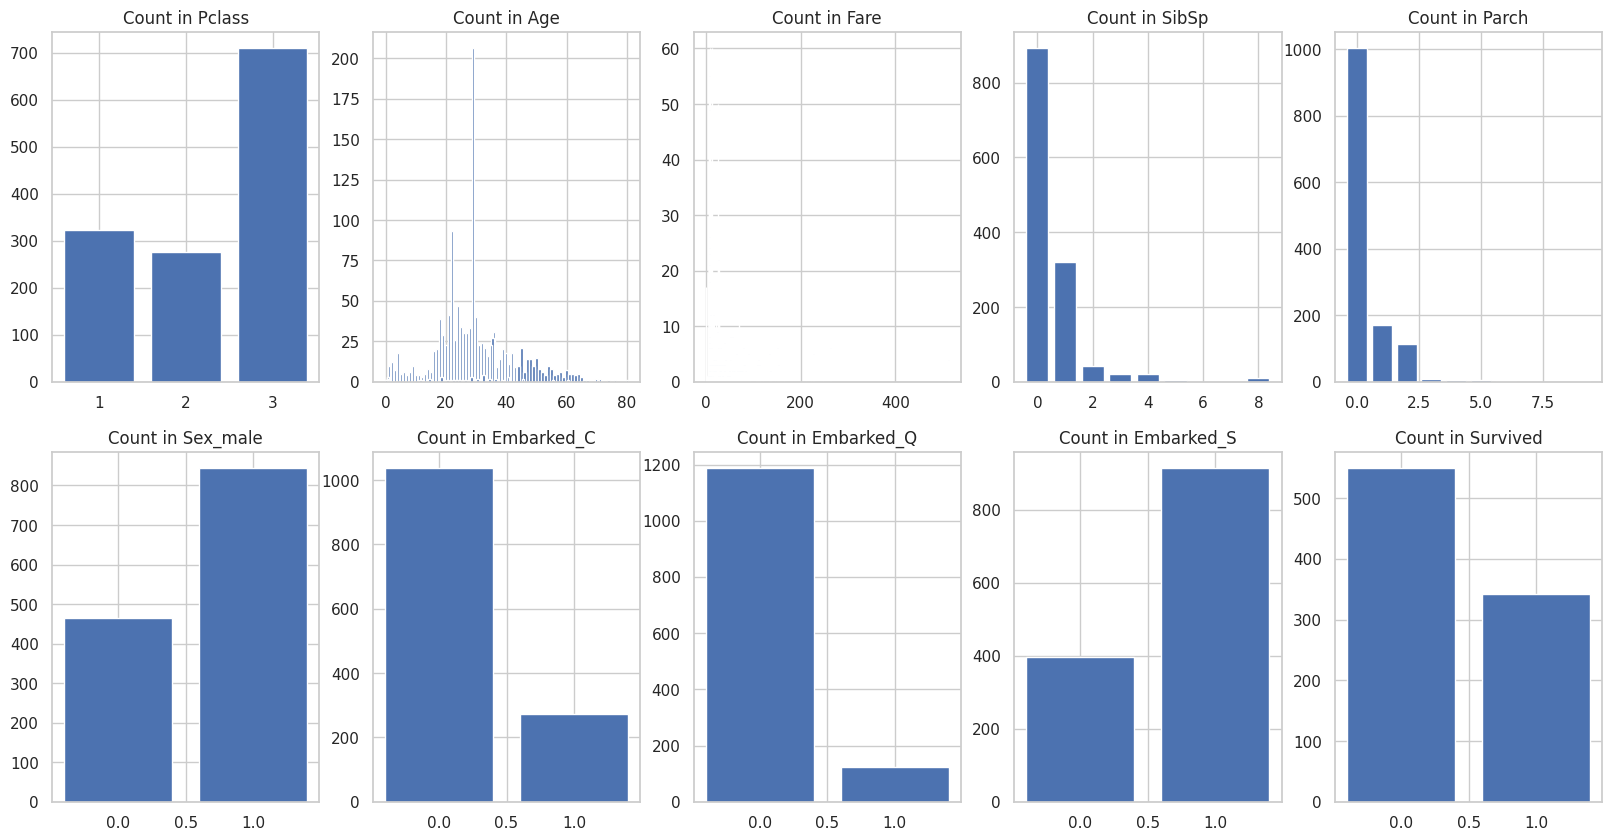

In [ ]:
from matplotlib import pyplot as plt

# A különböző oszlopokban megjelenő értékek darabszámai megjelenítve oszlopdiagrammok segítségével
f,ax = plt.subplots(2,len(x_cols + y_cols)//2)
f.set_size_inches(20,10)
for i in range(len(x_cols + y_cols)):
    row = i // (len(x_cols + y_cols) // 2)
    col = i % (len(x_cols + y_cols) // 2)
    column = (x_cols + y_cols)[i]
    value_counts = df[column].value_counts()
    #print(value_counts)
    ax[row, col].bar(value_counts.index, value_counts.values)
    ax[row, col].set_title(f'Count in {column}')
    ax[row, col]
plt.show()

## Passager Class vs Survival

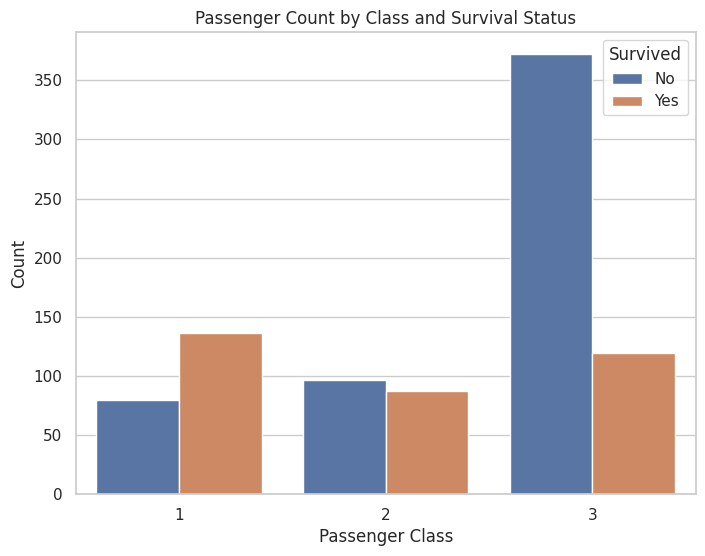

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If not already loaded, you can load the dataset as follows:
# titanic = pd.read_csv('titanic.csv')
# Alternatively, for a quick example using seaborn's version:
# titanic = sns.load_dataset("titanic")

plt.figure(figsize=(8,6))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Passenger Count by Class and Survival Status')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()


## Age Histrogram

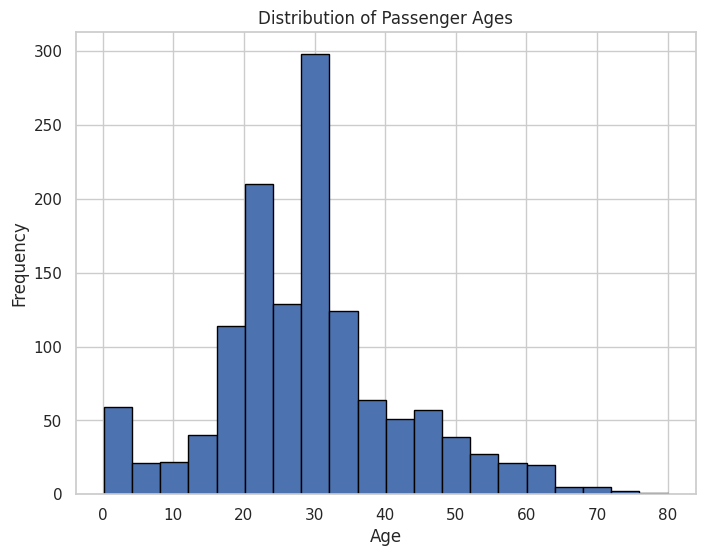

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df['Age'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Passenger Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

##  Scatterplot with Linear Regression: Age vs. Fare

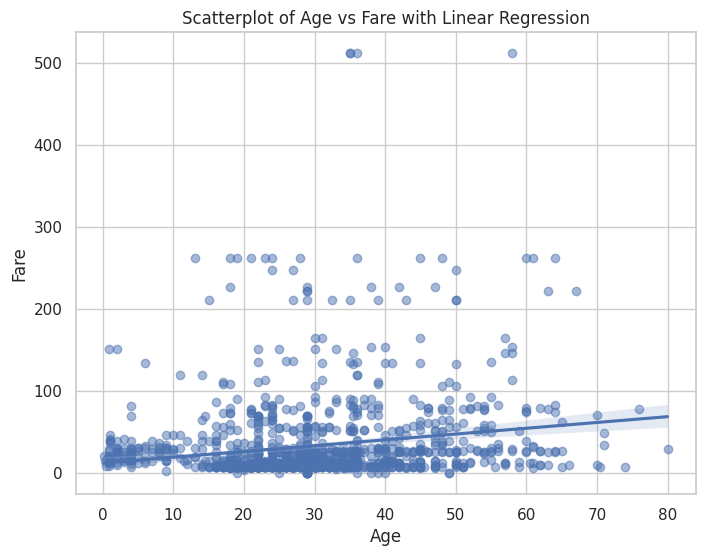

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(x='Age', y='Fare', data=df, scatter_kws={'alpha':0.5})
plt.title('Scatterplot of Age vs Fare with Linear Regression')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()


## Age vs. Survival Rate

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 26.0% of the points cannot be plac

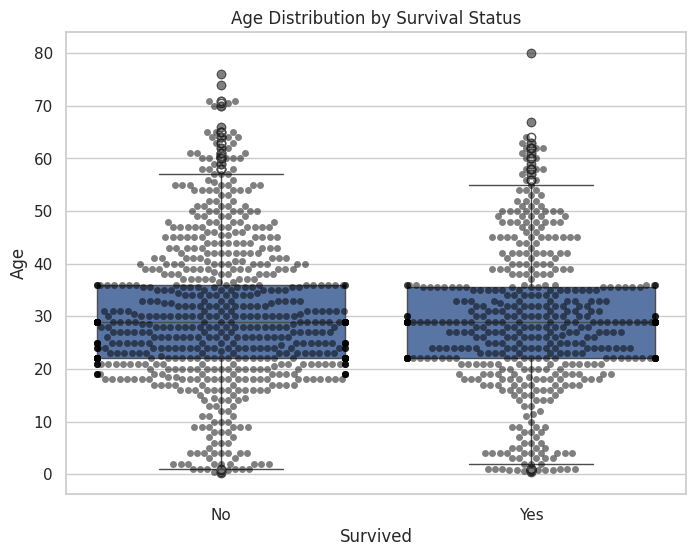

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(x='Survived', y='Age', data=df)
sns.swarmplot(x='Survived', y='Age', data=df, color='black', alpha=0.5)
plt.title('Age Distribution by Survival Status')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

## Survival Rate by Sex

In [ ]:
print(df.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


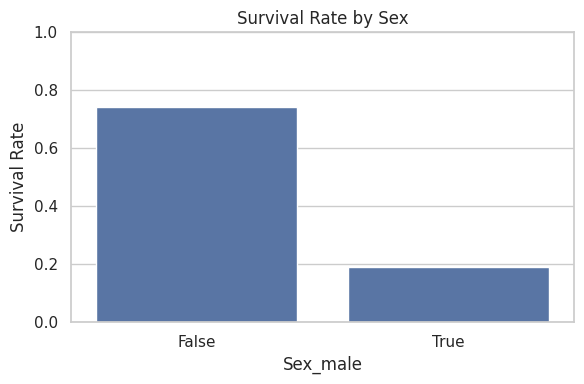

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set plot style
sns.set(style="whitegrid")

# 1. Survival Rate by Sex
survival_by_sex = df.groupby("Sex_male")["Survived"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="Sex_male", y="Survived", data=survival_by_sex)
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.xlabel("Sex_male")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



## Survival Rate by Fare

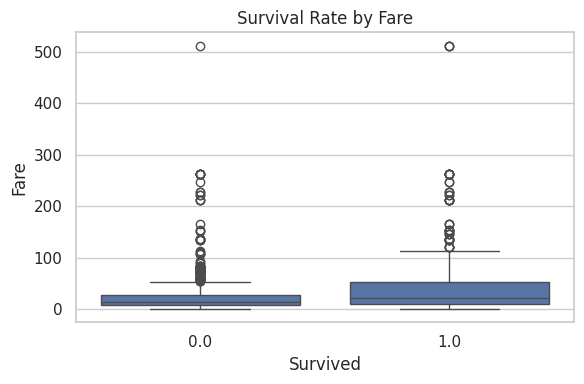

In [ ]:
# 2. Fare vs Survival (Boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(x="Survived", y="Fare", data=df)
plt.title("Survival Rate by Fare")
plt.xlabel("Survived")
plt.ylabel("Fare")
plt.tight_layout()
plt.show()

## Survival Rate by Embarked Port

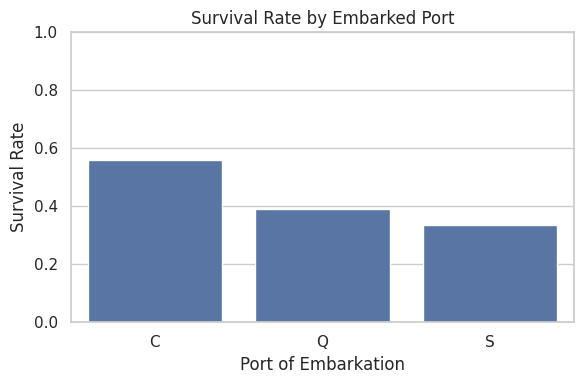

In [ ]:
# 3. Survival Rate by Embarked Port
survival_by_embarked = df.groupby("Embarked")["Survived"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="Embarked", y="Survived", data=survival_by_embarked)
plt.title("Survival Rate by Embarked Port")
plt.ylabel("Survival Rate")
plt.xlabel("Port of Embarkation")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Models

## Random Forest

In [ ]:
# numerical cols are separated earlier, called x_cols
x_cols

['Pclass',
 'Age',
 'Fare',
 'SibSp',
 'Parch',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Prepare X and y
X = train_df[x_cols]
y = train_df['Survived']

# Optional: create a validation set to evaluate performance
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate base model
y_val_pred = rf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.8268156424581006

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       105
         1.0       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix:
 [[92 13]
 [18 56]]


### GridSearch

Don't run, best parameters are already set

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_rf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


KeyboardInterrupt: 

### Eval

Accuracy : 0.9218
AUROC    : 0.9807

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9252    0.9429    0.9340       105
         1.0     0.9167    0.8919    0.9041        74

    accuracy                         0.9218       179
   macro avg     0.9210    0.9174    0.9190       179
weighted avg     0.9217    0.9218    0.9216       179



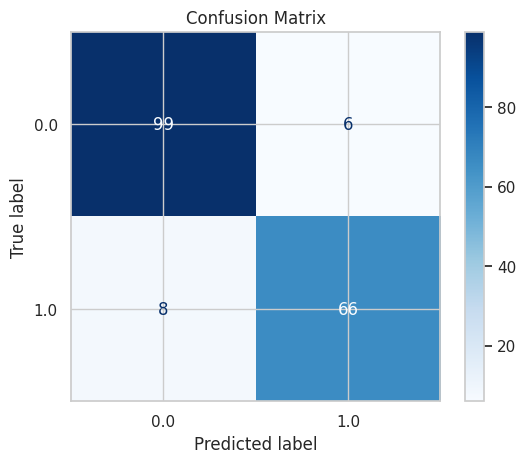

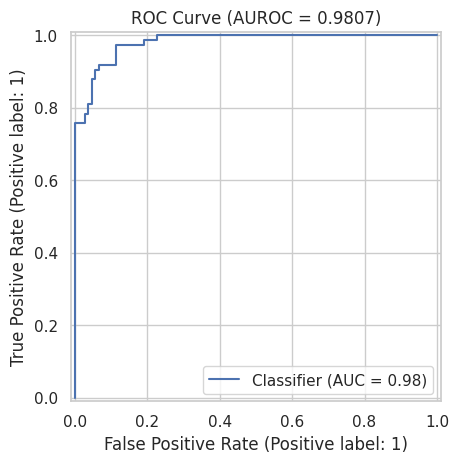

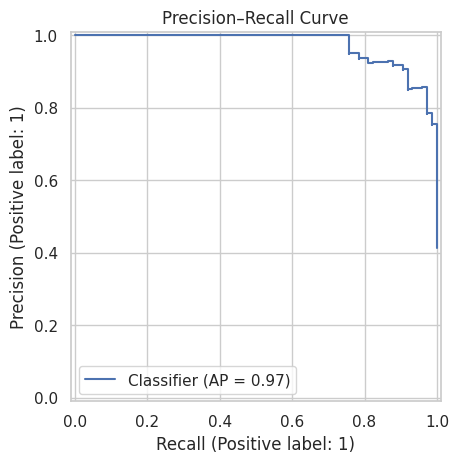

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# The best model is already trained
# Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

rf_final = RandomForestClassifier(bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X, y)

# 1) Get predictions and prediction-probabilities
y_val_pred  = rf_final.predict(X_val)
y_val_probs = rf_final.predict_proba(X_val)[:, 1]

# 2) Print scalar metrics
acc   = accuracy_score(y_val, y_val_pred)
auc   = roc_auc_score(y_val, y_val_probs)
print(f"Accuracy : {acc:.4f}")
print(f"AUROC    : {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

# 3) Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap="Blues", display_labels=rf_final.classes_)
plt.title("Confusion Matrix")
plt.show()

# 4) Plot ROC Curve
RocCurveDisplay.from_predictions(y_val, y_val_probs)
plt.title(f"ROC Curve (AUROC = {auc:.4f})")
plt.show()

# 5) Plot Precision–Recall Curve
PrecisionRecallDisplay.from_predictions(y_val, y_val_probs)
plt.title("Precision–Recall Curve")
plt.show()

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Prepare X and y
X = train_df[x_cols]
y = train_df['Survived']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

# Evaluate base model
y_val_pred = gbm.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.8212290502793296

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


Confusion Matrix:
 [[93 12]
 [20 54]]


### GridSearch

Don't run, best parameters are already set

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
}


# Perform grid search
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_gbm = grid_search.best_estimator_
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

### Eval

Accuracy : 0.9441
AUROC    : 0.9843

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9524    0.9524    0.9524       105
         1.0     0.9324    0.9324    0.9324        74

    accuracy                         0.9441       179
   macro avg     0.9424    0.9424    0.9424       179
weighted avg     0.9441    0.9441    0.9441       179



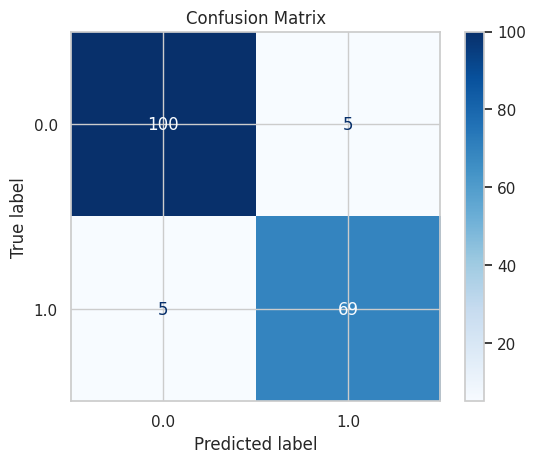

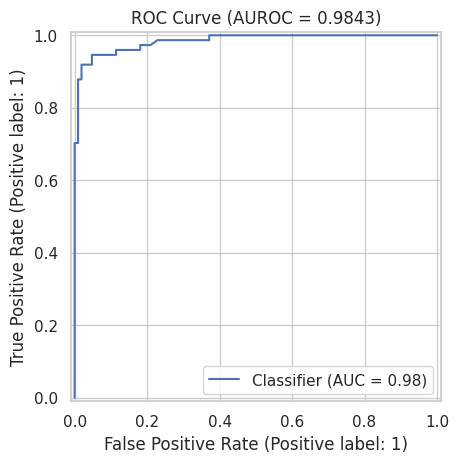

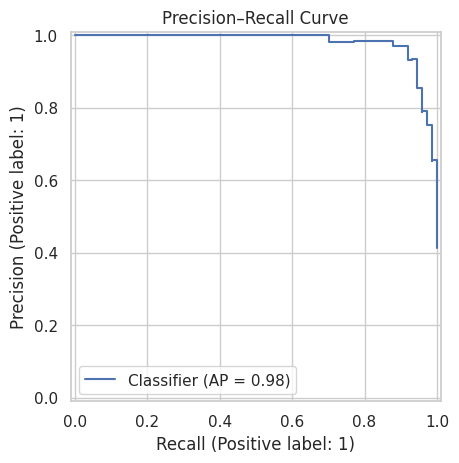

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
# Final model trained on full training data
gbm_final = GradientBoostingClassifier(random_state=42, max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=5,  n_estimators=100   )
gbm_final.fit(X, y)

# 1) Get predictions and prediction-probabilities
y_val_pred  = gbm_final.predict(X_val)
y_val_probs = gbm_final.predict_proba(X_val)[:, 1]

# 2) Print scalar metrics
acc   = accuracy_score(y_val, y_val_pred)
auc   = roc_auc_score(y_val, y_val_probs)
print(f"Accuracy : {acc:.4f}")
print(f"AUROC    : {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

# 3) Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap="Blues", display_labels=rf_final.classes_)
plt.title("Confusion Matrix")
plt.show()

# 4) Plot ROC Curve
RocCurveDisplay.from_predictions(y_val, y_val_probs)
plt.title(f"ROC Curve (AUROC = {auc:.4f})")
plt.show()

# 5) Plot Precision–Recall Curve
PrecisionRecallDisplay.from_predictions(y_val, y_val_probs)
plt.title("Precision–Recall Curve")
plt.show()

## Extreme GB

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Prepare X and y
X = train_df[x_cols]
y = train_df['Survived']

# Train-test split (val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Extreme Gradient Boosting Classifier model
xgb = XGBClassifier(n_estimators=10, objective='binary:logistic', random_state=42)
#xgb = XGBClassifier(n_estimators=10, max_depth=2, learning_rate=1, objective='binary:logistic', random_state=42)
xgb.fit(X_train, y_train)

# Evaluate base model
y_val_pred = xgb.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Final model trained on full data
xgb_all = XGBClassifier(n_estimators=100, random_state=40)
xgb_all.fit(X, y)

# Predict on test_df
X_test = test_df[x_cols]
test_predictions = xgb_all.predict(X_test)

# Attaching predictions to test.df
test_df['Survived_pred_xgb'] = test_predictions

Validation Accuracy: 0.8379888268156425

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       105
         1.0       0.86      0.73      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179


Confusion Matrix:
 [[96  9]
 [20 54]]


<ipython-input-91-93fc33d26e71>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Survived_pred_xgb'] = test_predictions


### GridSearch

Don't run, best parameters are already set

In [ ]:
from sklearn.model_selection import GridSearchCV

rerun_search = False
if rerun_search:
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],        # 10, 200, 300 aren't in the best ever
        'max_depth': [3, 5, 7, None],
        'learning_rate': [0.05, 0.1, 0.2, 0.5],     # 1 is far too high
        'subsample': [0.3, 0.6, 1],
        'tree_method': ['exact', 'approx', 'hist'],
        #'grow_policy': ['depthwise', 'lossguide'],  # lossguide doesn't work with exact, but it isn't better than depthwise anyways
    }


    # Perform grid search
    grid_search = GridSearchCV(
        XGBClassifier(random_state=42),
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search.fit(X_train, y_train)

    # Best model and parameters
    best_xgb = grid_search.best_estimator_
    print("Best Parameters from GridSearchCV:", grid_search.best_params_)

### Eval

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Best Parameters from GridSearchCV and manual testing: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1, 'tree_method': 'approx'}

# Final model trained on full data
xgb_final_eval = XGBClassifier(learning_rate=0.1, max_depth=7, subsample=1, tree_method='approx', n_estimators=50, random_state=42)
xgb_final_eval.fit(X_train, y_train)

# Evaluate
y_val_pred = xgb_final_eval.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
#print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
#print("\nAUROC Score:", roc_auc_score(y_val, y_val_pred), "\n")

Validation Accuracy: 0.8547486033519553

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       105
         1.0       0.83      0.81      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



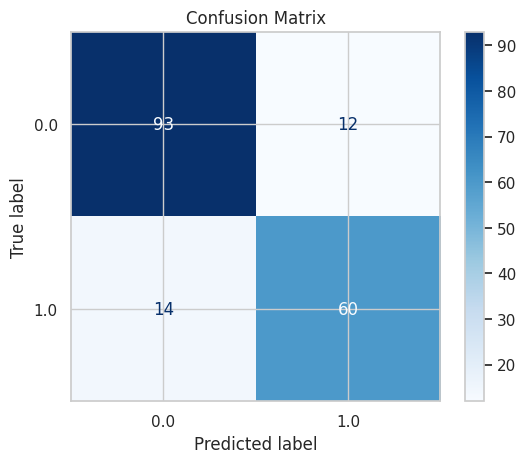

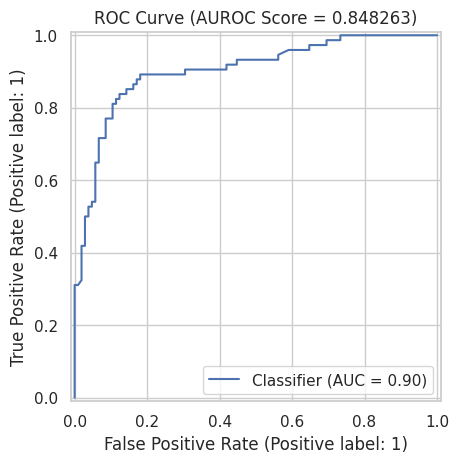

In [ ]:
# Confusion matrix display
ConfusionMatrixDisplay.from_estimator(xgb_final_eval, X_val, y_val, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve display
y_val_probs = xgb_final_eval.predict_proba(X_val)[:, 1]

RocCurveDisplay.from_predictions(y_val, y_val_probs)
plt.title(f"ROC Curve (AUROC Score = {roc_auc_score(y_val, y_val_pred):.6f})")
plt.show()


### Final model and results

In [ ]:
# Final model trained on full data
xgb_final = XGBClassifier(learning_rate=0.1, max_depth=3, subsample=1, tree_method='approx', n_estimators=100, random_state=42)
xgb_final.fit(X, y)

# Predict on test_df
X_test = test_df[x_cols]
test_predictions = xgb_final.predict(X_test)

# Attaching predictions to test.df
test_df['Survived_pred_xgb'] = test_predictions

<ipython-input-94-0bf0eafd055a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Survived_pred_xgb'] = test_predictions


# Összehasonlítás

Random Forest: Pontosság: 0.9218. Összesen 8db FN és 6db FP klasszifikáció történt. A ROC görbe közel halad el a bal felső sarokhoz, ami jó teljesítményt jelent. A PRC sokáig egyenesen és magasan halad, megközelíti a jobb felső sarkot, ezzel szintés nagyon jó teljesítményt jelezve.  

Gradient Boosting: Pontosság 0.9441. Összesen 5db FN és 5db FP érték van, ez 37.5% és 16.6%-os javulást jelent, ami nagyon jónak mondható. A ROC és PRC közelebb haladnak a megfelelő sarkokhoz, mint az RF esetében.

Extreme Gradient Boosting: Pontosság: 0.8547, ez lényegesen elmaradt a RF és GBM eredményétől. 12db FN és 14FP értéket kaptunk, ami 140% és 180% romlás a GBM-hez képest. A ROC és PRC görbékről is hasonló adatok olvashatók le, nem közelíti meg olyan mértékben az ideális modelt, mint az előző kettő.

# Applikáció Terv

Gradios felület, ahol inputként megadhatjuk karakterünk adatait és a model megadja, hogy túléltük volna vagy sem.